The following code is a work in progress. It has incorporated a variety of methods to solve this problem along with various additions. The goal is to combine multiple methodologies to create a hybrid / ensemble methodology. To this end, it is worth noting the following references:

https://www.kaggle.com/code/ambrosm/mabe-nearest-neighbors-the-original
https://www.kaggle.com/code/snnguynvnk19hl/mabe-challenge-ml
https://www.kaggle.com/code/xbar19/mabe-catboost-baseline
https://www.kaggle.com/code/yusuketogashi/mabe-launchpad-start-simple-localcv

In [1]:
"""
MABe Challenge - Enhanced with Comprehensive Visualizations (Fault-Tolerant)
============================================================================
Complete implementation with detailed analytics and robust error handling
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import itertools
import warnings
import json
import os
import gc
from collections import defaultdict, Counter
from datetime import datetime
import time

# Import visualization libraries with error handling
try:
    import plotly.graph_objects as go
    import plotly.express as px
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
except ImportError:
    PLOTLY_AVAILABLE = False
    print("⚠️ Plotly not available - interactive visualizations disabled")

import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

from sklearn.base import ClassifierMixin, BaseEstimator, clone
from sklearn.model_selection import cross_val_predict, GroupKFold
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import polars as pl

warnings.filterwarnings('ignore')

# Enhanced visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 15

# Configuration
validate_or_submit = 'submit'
verbose = True
create_visualizations = True
save_plots = True
plot_dir = 'figures'

if save_plots:
    os.makedirs(plot_dir, exist_ok=True)
    print(f"📁 Created visualization directory: {plot_dir}")

# Performance tracking
start_time = time.time()
performance_metrics = {
    'configurations_processed': 0,
    'single_mouse_batches': 0,
    'pair_batches': 0,
    'features_extracted': 0,
    'predictions_made': 0,
    'models_trained': 0,
    'actions_processed': 0
}

print("\n" + "="*80)
print(" "*15 + "🐭 MABe CHALLENGE - ENHANCED VISUALIZATION VERSION 🐭")
print("="*80)
print(f"📅 Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🔧 Mode: {validate_or_submit.upper()}")
print(f"📊 Visualizations: {'ENABLED' if create_visualizations else 'DISABLED'}")
print(f"💾 Save Plots: {'YES' if save_plots else 'NO'}")
print("="*80 + "\n")

📁 Created visualization directory: figures

               🐭 MABe CHALLENGE - ENHANCED VISUALIZATION VERSION 🐭
📅 Start Time: 2025-09-25 23:14:12
🔧 Mode: SUBMIT
📊 Visualizations: ENABLED
💾 Save Plots: YES



In [2]:
def safe_json_loads(x):
    """Safely load JSON, returning empty list for NaN values"""
    if pd.isna(x):
        return []
    try:
        return json.loads(x)
    except:
        return []

def create_data_overview_plots(train_df, test_df):
    """Create comprehensive data overview visualizations with error handling"""
    try:
        print("\n" + "="*60)
        print("📊 CREATING DATA OVERVIEW VISUALIZATIONS")
        print("="*60)
        
        fig = plt.figure(figsize=(20, 14))
        gs = gridspec.GridSpec(4, 4, hspace=0.3, wspace=0.3)
        
        # 1. Videos per laboratory
        try:
            ax1 = fig.add_subplot(gs[0, :2])
            lab_counts = train_df['lab_id'].value_counts().head(20)
            colors = sns.color_palette("husl", len(lab_counts))
            bars = ax1.bar(range(len(lab_counts)), lab_counts.values, color=colors, edgecolor='black', linewidth=0.5)
            ax1.set_xticks(range(len(lab_counts)))
            ax1.set_xticklabels(lab_counts.index, rotation=45, ha='right', fontsize=9)
            ax1.set_title('Videos per Laboratory (Top 20)', fontsize=12, fontweight='bold')
            ax1.set_ylabel('Number of Videos')
            ax1.grid(True, alpha=0.3, axis='y')
            
            for bar in bars:
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                        f'{int(height)}', ha='center', va='bottom', fontsize=8)
        except Exception as e:
            print(f"    ⚠️ Lab counts plot failed: {e}")
        
        # 2. Mice distribution
        try:
            ax2 = fig.add_subplot(gs[0, 2])
            mice_dist = train_df['n_mice'].value_counts().sort_index()
            wedges, texts, autotexts = ax2.pie(mice_dist.values, 
                                                labels=[f'{i} mice' for i in mice_dist.index],
                                                autopct='%1.1f%%',
                                                startangle=90,
                                                colors=plt.cm.Set3.colors)
            ax2.set_title('Mice per Video Distribution', fontsize=12, fontweight='bold')
        except Exception as e:
            print(f"    ⚠️ Mice distribution plot failed: {e}")
        
        # 3. Body parts configuration
        try:
            ax3 = fig.add_subplot(gs[0, 3])
            body_parts_count = train_df['body_parts_tracked'].apply(safe_json_loads).apply(len)
            ax3.hist(body_parts_count, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
            ax3.set_xlabel('Number of Body Parts')
            ax3.set_ylabel('Frequency')
            ax3.set_title('Body Parts per Configuration', fontsize=12, fontweight='bold')
            if len(body_parts_count) > 0:
                ax3.axvline(body_parts_count.mean(), color='red', linestyle='--', 
                           label=f'Mean: {body_parts_count.mean():.1f}')
                ax3.legend()
            ax3.grid(True, alpha=0.3)
        except Exception as e:
            print(f"    ⚠️ Body parts plot failed: {e}")
        
        # 4. Behavior types distribution
        try:
            ax4 = fig.add_subplot(gs[1, :2])
            behaviors_count = train_df['behaviors_labeled'].apply(safe_json_loads).apply(len)
            valid_behaviors = behaviors_count[behaviors_count > 0]
            
            if len(valid_behaviors) > 0:
                ax4.hist(valid_behaviors, bins=30, color='coral', edgecolor='black', alpha=0.7)
                ax4.set_xlabel('Number of Behavior Types')
                ax4.set_ylabel('Frequency')
                ax4.set_title('Behavior Types per Video', fontsize=12, fontweight='bold')
                ax4.axvline(valid_behaviors.mean(), color='blue', linestyle='--',
                           label=f'Mean: {valid_behaviors.mean():.1f}')
                ax4.axvline(valid_behaviors.median(), color='green', linestyle='--',
                           label=f'Median: {valid_behaviors.median():.1f}')
                ax4.legend()
                ax4.grid(True, alpha=0.3)
            else:
                ax4.text(0.5, 0.5, 'No valid behavior data', 
                        transform=ax4.transAxes, ha='center', va='center')
        except Exception as e:
            print(f"    ⚠️ Behavior distribution plot failed: {e}")
        
        # 5. Top behavior actions
        try:
            ax5 = fig.add_subplot(gs[1, 2:])
            all_behaviors = []
            for behaviors_str in train_df['behaviors_labeled'].dropna():
                try:
                    behaviors = json.loads(behaviors_str)
                    for b in behaviors:
                        parts = b.replace("'", "").split(',')
                        if len(parts) == 3:
                            all_behaviors.append(parts[2])
                except:
                    continue
            
            if all_behaviors:
                behavior_counts = Counter(all_behaviors)
                top_behaviors = dict(behavior_counts.most_common(15))
                
                ax5.barh(range(len(top_behaviors)), list(top_behaviors.values()), 
                        color='steelblue', edgecolor='black', linewidth=0.5)
                ax5.set_yticks(range(len(top_behaviors)))
                ax5.set_yticklabels(list(top_behaviors.keys()), fontsize=9)
                ax5.set_xlabel('Frequency')
                ax5.set_title('Top 15 Behavior Actions', fontsize=12, fontweight='bold')
                ax5.grid(True, alpha=0.3, axis='x')
            else:
                ax5.text(0.5, 0.5, 'No behavior data available', 
                        transform=ax5.transAxes, ha='center', va='center')
        except Exception as e:
            print(f"    ⚠️ Behavior actions plot failed: {e}")
            behavior_counts = {}
            top_behaviors = {}
        
        # 6. Lab-Behavior heatmap
        try:
            ax6 = fig.add_subplot(gs[2, :])
            if all_behaviors and len(top_behaviors) > 0:
                top_labs = lab_counts.head(10).index
                lab_behavior_matrix = []
                
                for lab in top_labs:
                    lab_data = train_df[train_df['lab_id'] == lab]
                    lab_behaviors = []
                    for behaviors_str in lab_data['behaviors_labeled'].dropna():
                        try:
                            behaviors = json.loads(behaviors_str)
                            lab_behaviors.extend(behaviors)
                        except:
                            continue
                    
                    lab_behavior_counts = []
                    for behavior in list(top_behaviors.keys())[:10]:
                        count = sum(1 for b in lab_behaviors if behavior in b)
                        lab_behavior_counts.append(count)
                    lab_behavior_matrix.append(lab_behavior_counts)
                
                if lab_behavior_matrix:
                    im = ax6.imshow(lab_behavior_matrix, aspect='auto', cmap='YlOrRd')
                    ax6.set_xticks(range(min(10, len(top_behaviors))))
                    ax6.set_xticklabels(list(top_behaviors.keys())[:10], rotation=45, ha='right', fontsize=9)
                    ax6.set_yticks(range(len(top_labs)))
                    ax6.set_yticklabels(top_labs, fontsize=9)
                    ax6.set_title('Lab-Behavior Frequency Heatmap', fontsize=12, fontweight='bold')
                    plt.colorbar(im, ax=ax6, label='Frequency')
                else:
                    ax6.axis('off')
                    ax6.text(0.5, 0.5, 'Insufficient data for heatmap', 
                            transform=ax6.transAxes, ha='center', va='center')
            else:
                ax6.axis('off')
                ax6.text(0.5, 0.5, 'Insufficient data for heatmap', 
                        transform=ax6.transAxes, ha='center', va='center')
        except Exception as e:
            print(f"    ⚠️ Heatmap failed: {e}")
        
        # 7. Statistics summary
        try:
            ax7 = fig.add_subplot(gs[3, :])
            ax7.axis('off')
            
            n_missing_behaviors = train_df['behaviors_labeled'].isna().sum()
            
            # Compute statistics safely
            avg_behaviors = valid_behaviors.mean() if 'valid_behaviors' in locals() and len(valid_behaviors) > 0 else 0
            max_behaviors = behaviors_count.max() if 'behaviors_count' in locals() and len(behaviors_count) > 0 else 0
            min_body_parts = body_parts_count.min() if 'body_parts_count' in locals() and len(body_parts_count) > 0 else 0
            max_body_parts = body_parts_count.max() if 'body_parts_count' in locals() and len(body_parts_count) > 0 else 0
            mean_body_parts = body_parts_count.mean() if 'body_parts_count' in locals() and len(body_parts_count) > 0 else 0
            
            stats_text = f"""
    DATASET STATISTICS SUMMARY
    {'='*70}
    
    TRAINING DATA:
    • Total Videos: {len(train_df):,}
    • Videos with Missing Behaviors: {n_missing_behaviors} ({100*n_missing_behaviors/len(train_df):.1f}%)
    • Unique Laboratories: {train_df['lab_id'].nunique()}
    • Average Mice per Video: {train_df['n_mice'].mean():.2f}
    • Total Unique Body Part Configurations: {train_df['body_parts_tracked'].nunique()}
    
    TEST DATA:
    • Total Videos: {len(test_df):,}
    • Unique Laboratories: {test_df['lab_id'].nunique()}
    
    BEHAVIOR ANALYSIS:
    • Total Unique Behaviors: {len(behavior_counts) if 'behavior_counts' in locals() else 0}
    • Most Common Behavior: {list(top_behaviors.keys())[0] if 'top_behaviors' in locals() and top_behaviors else 'N/A'} 
    • Average Behaviors per Video: {avg_behaviors:.1f}
    • Max Behaviors in Single Video: {max_behaviors}
    
    BODY PARTS:
    • Min Body Parts: {min_body_parts}
    • Max Body Parts: {max_body_parts}
    • Mean Body Parts: {mean_body_parts:.1f}
    """
            
            ax7.text(0.05, 0.95, stats_text, transform=ax7.transAxes, fontsize=10,
                    verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.3))
        except Exception as e:
            print(f"    ⚠️ Statistics summary failed: {e}")
        
        plt.suptitle('MABe Dataset Comprehensive Overview', fontsize=16, fontweight='bold')
        
        if save_plots:
            try:
                plt.savefig(os.path.join(plot_dir, 'data_overview.png'), dpi=100, bbox_inches='tight')
                print("    💾 Saved: data_overview.png")
            except Exception as e:
                print(f"    ⚠️ Failed to save plot: {e}")
        
        plt.show()
        
        return behavior_counts if 'behavior_counts' in locals() else {}
    
    except Exception as e:
        print(f"❌ Data overview visualization failed: {e}")
        return {}

def create_feature_analysis_plots(features_df, feature_type='single', section_num=1):
    """Create feature analysis with error handling"""
    try:
        if features_df is None or features_df.empty:
            return
            
        print(f"\n📈 Creating feature analysis for {feature_type} mouse...")
        
        numeric_cols = [col for col in features_df.columns if features_df[col].dtype in [np.float64, np.int64]]
        feature_cols = [col for col in numeric_cols if col not in ['video_frame', 'start_frame', 'stop_frame']]
        
        if len(feature_cols) == 0:
            print("    ⚠️ No numeric features to visualize")
            return
        
        if len(feature_cols) > 20:
            feature_cols = list(np.random.choice(feature_cols, 20, replace=False))
        
        # Feature distributions
        fig = plt.figure(figsize=(18, 12))
        n_features = min(12, len(feature_cols))
        
        for i in range(n_features):
            try:
                ax = plt.subplot(4, 3, i+1)
                data = features_df[feature_cols[i]].dropna()
                if len(data) > 0:
                    ax.hist(data, bins=30, color='lightblue', edgecolor='black', alpha=0.7)
                    ax.set_title(feature_cols[i][:20], fontsize=10)
                    ax.set_xlabel('Value', fontsize=9)
                    ax.set_ylabel('Frequency', fontsize=9)
                    
                    mean_val = data.mean()
                    median_val = data.median()
                    ax.axvline(mean_val, color='red', linestyle='--', alpha=0.5, linewidth=1)
                    ax.axvline(median_val, color='green', linestyle='--', alpha=0.5, linewidth=1)
                    
                    stats_text = f'μ={mean_val:.2f}\nM={median_val:.2f}'
                    ax.text(0.95, 0.95, stats_text, transform=ax.transAxes,
                           fontsize=8, verticalalignment='top', horizontalalignment='right',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            except Exception as e:
                print(f"    ⚠️ Feature {i} plot failed: {e}")
        
        plt.suptitle(f'Feature Distributions - {feature_type.capitalize()} Mouse (Config {section_num})', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        if save_plots:
            try:
                plt.savefig(os.path.join(plot_dir, f'feature_dist_{feature_type}_{section_num}.png'), 
                           dpi=100, bbox_inches='tight')
            except:
                pass
        plt.show()
        
        # Correlation heatmap
        if len(feature_cols) > 3:
            try:
                print("    📊 Creating correlation heatmap...")
                fig, ax = plt.subplots(figsize=(12, 10))
                
                corr_matrix = features_df[feature_cols].corr()
                mask = np.triu(np.ones_like(corr_matrix), k=1)
                
                sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0,
                           square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                           ax=ax, vmin=-1, vmax=1)
                
                ax.set_title(f'Feature Correlation Matrix - {feature_type.capitalize()} Mouse', 
                            fontsize=14, fontweight='bold')
                plt.tight_layout()
                
                if save_plots:
                    try:
                        plt.savefig(os.path.join(plot_dir, f'correlation_{feature_type}_{section_num}.png'), 
                                   dpi=100, bbox_inches='tight')
                    except:
                        pass
                plt.show()
            except Exception as e:
                print(f"    ⚠️ Correlation heatmap failed: {e}")
                
    except Exception as e:
        print(f"❌ Feature analysis failed: {e}")

def create_performance_tracking_plot(f1_scores, predictions_count):
    """Create performance plots with error handling"""
    try:
        if not f1_scores:
            return
            
        print("\n🎯 Creating performance analysis plots...")
        
        f1_df = pd.DataFrame(f1_scores, columns=['body_parts', 'action', 'f1_score'])
        
        fig = plt.figure(figsize=(20, 12))
        
        # Multiple performance visualizations with individual error handling
        plot_functions = [
            lambda: create_f1_by_action(fig, f1_df),
            lambda: create_f1_histogram(fig, f1_df),
            lambda: create_performance_by_config(fig, f1_df),
            lambda: create_top_bottom_performers(fig, f1_df),
            lambda: create_prediction_accumulation(fig, predictions_count),
            lambda: create_performance_summary(fig, f1_df, predictions_count)
        ]
        
        for i, plot_func in enumerate(plot_functions, 1):
            try:
                plot_func()
            except Exception as e:
                print(f"    ⚠️ Performance subplot {i} failed: {e}")
        
        plt.suptitle('Comprehensive Model Performance Analysis', fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        if save_plots:
            try:
                plt.savefig(os.path.join(plot_dir, 'performance_analysis.png'), 
                           dpi=100, bbox_inches='tight')
            except:
                pass
        plt.show()
        
    except Exception as e:
        print(f"❌ Performance tracking plot failed: {e}")

def create_f1_by_action(fig, f1_df):
    ax1 = plt.subplot(3, 3, 1)
    action_f1 = f1_df.groupby('action')['f1_score'].agg(['mean', 'std']).sort_values('mean', ascending=False)
    
    ax1.barh(range(len(action_f1)), action_f1['mean'], xerr=action_f1['std'].fillna(0),
            color='green', alpha=0.7, capsize=3)
    ax1.set_yticks(range(len(action_f1)))
    ax1.set_yticklabels(action_f1.index, fontsize=9)
    ax1.set_xlabel('F1 Score')
    ax1.set_title('F1 Score by Action (with std)', fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')

def create_f1_histogram(fig, f1_df):
    ax2 = plt.subplot(3, 3, 2)
    ax2.hist(f1_df['f1_score'], bins=25, color='blue', edgecolor='black', alpha=0.7)
    ax2.set_xlabel('F1 Score')
    ax2.set_ylabel('Frequency')
    ax2.set_title('F1 Score Distribution', fontweight='bold')
    ax2.axvline(f1_df['f1_score'].mean(), color='red', linestyle='--',
               label=f'Mean: {f1_df["f1_score"].mean():.3f}')
    ax2.axvline(f1_df['f1_score'].median(), color='green', linestyle='--',
               label=f'Median: {f1_df["f1_score"].median():.3f}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

def create_performance_by_config(fig, f1_df):
    ax3 = plt.subplot(3, 3, 3)
    config_f1 = f1_df.groupby('body_parts')['f1_score'].mean()
    ax3.plot(range(len(config_f1)), config_f1.values, 'o-', color='purple', linewidth=2, markersize=8)
    ax3.set_xlabel('Configuration Index')
    ax3.set_ylabel('Mean F1 Score')
    ax3.set_title('Performance by Configuration', fontweight='bold')
    ax3.grid(True, alpha=0.3)

def create_top_bottom_performers(fig, f1_df):
    ax4 = plt.subplot(3, 3, 4)
    action_f1 = f1_df.groupby('action')['f1_score'].mean().sort_values(ascending=False)
    
    if len(action_f1) > 0:
        top_5 = action_f1.head(5)
        bottom_5 = action_f1.tail(5) if len(action_f1) > 5 else pd.Series()
        all_performers = pd.concat([top_5, bottom_5])
        colors = ['green'] * len(top_5) + ['red'] * len(bottom_5)
        
        ax4.bar(range(len(all_performers)), all_performers.values, color=colors, alpha=0.7)
        ax4.set_xticks(range(len(all_performers)))
        ax4.set_xticklabels(all_performers.index, rotation=45, ha='right', fontsize=8)
        ax4.set_ylabel('F1 Score')
        ax4.set_title('Best & Worst Performing Actions', fontweight='bold')
        ax4.grid(True, alpha=0.3, axis='y')

def create_prediction_accumulation(fig, predictions_count):
    ax5 = plt.subplot(3, 3, 5)
    if predictions_count:
        ax5.plot(range(len(predictions_count)), np.cumsum(predictions_count), 
                'b-', linewidth=2)
        ax5.fill_between(range(len(predictions_count)), 0, np.cumsum(predictions_count), 
                         alpha=0.3, color='blue')
    ax5.set_xlabel('Configuration')
    ax5.set_ylabel('Cumulative Predictions')
    ax5.set_title('Prediction Accumulation', fontweight='bold')
    ax5.grid(True, alpha=0.3)

def create_performance_summary(fig, f1_df, predictions_count):
    ax6 = plt.subplot(3, 3, 6)
    ax6.axis('off')
    
    action_f1 = f1_df.groupby('action')['f1_score'].mean().sort_values(ascending=False)
    
    stats_text = f"""
    PERFORMANCE SUMMARY
    {'-'*40}
    
    F1 STATISTICS:
    • Mean: {f1_df['f1_score'].mean():.4f}
    • Median: {f1_df['f1_score'].median():.4f}
    • Std: {f1_df['f1_score'].std():.4f}
    • Min: {f1_df['f1_score'].min():.4f}
    • Max: {f1_df['f1_score'].max():.4f}
    
    BEST PERFORMERS:
    1. {action_f1.index[0] if len(action_f1) > 0 else 'N/A'}: {action_f1.iloc[0] if len(action_f1) > 0 else 0:.3f}
    2. {action_f1.index[1] if len(action_f1) > 1 else 'N/A'}: {action_f1.iloc[1] if len(action_f1) > 1 else 0:.3f}
    3. {action_f1.index[2] if len(action_f1) > 2 else 'N/A'}: {action_f1.iloc[2] if len(action_f1) > 2 else 0:.3f}
    
    TOTALS:
    • Actions: {f1_df['action'].nunique()}
    • Configurations: {f1_df['body_parts'].nunique()}
    • Total Predictions: {sum(predictions_count) if predictions_count else 0:,}
    """
    
    ax6.text(0.1, 0.9, stats_text, transform=ax6.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace')

def create_interactive_dashboard(train_df, test_df, f1_scores=None):
    """Create interactive dashboard with error handling"""
    if not PLOTLY_AVAILABLE:
        print("    ⚠️ Plotly not available - skipping interactive dashboard")
        return
    
    try:
        print("\n🎨 Creating interactive dashboard...")
        
        fig = make_subplots(
            rows=3, cols=3,
            subplot_titles=('Videos per Lab', 'Mice Distribution', 'Body Parts Config',
                           'Behavior Types', 'Lab Distribution', 'Configuration Complexity',
                           'Training Size', 'Test Coverage', 'Dataset Balance'),
            specs=[[{'type': 'bar'}, {'type': 'pie'}, {'type': 'box'}],
                   [{'type': 'scatter'}, {'type': 'bar'}, {'type': 'scatter'}],
                   [{'type': 'histogram'}, {'type': 'bar'}, {'type': 'indicator'}]]
        )
        
        # Add traces with error handling
        try:
            lab_counts = train_df['lab_id'].value_counts().head(15)
            fig.add_trace(
                go.Bar(x=lab_counts.index, y=lab_counts.values, 
                      marker_color='lightblue', name='Videos'),
                row=1, col=1
            )
        except:
            pass
        
        try:
            mice_dist = train_df['n_mice'].value_counts()
            fig.add_trace(
                go.Pie(labels=[f'{i} mice' for i in mice_dist.index], 
                      values=mice_dist.values, name='Mice'),
                row=1, col=2
            )
        except:
            pass
        
        try:
            body_parts_counts = train_df['body_parts_tracked'].apply(safe_json_loads).apply(len)
            fig.add_trace(
                go.Box(y=body_parts_counts.values, name='Body Parts'),
                row=1, col=3
            )
        except:
            pass
        
        fig.update_layout(
            title_text="MABe Challenge Interactive Dashboard",
            showlegend=False,
            height=900,
            width=1400
        )
        
        fig.show()
        
        if save_plots:
            try:
                fig.write_html(os.path.join(plot_dir, "interactive_dashboard.html"))
                print("    💾 Saved interactive dashboard as HTML")
            except Exception as e:
                print(f"    ⚠️ Failed to save interactive dashboard: {e}")
                
    except Exception as e:
        print(f"❌ Interactive dashboard failed: {e}")

In [3]:
# Custom classes for the model
class TrainOnSubsetClassifier(ClassifierMixin, BaseEstimator):
    def __init__(self, estimator, n_samples):
        self.estimator = estimator
        self.n_samples = n_samples

    def fit(self, X, y):
        downsample = max(1, len(X) // self.n_samples)
        self.estimator.fit(np.array(X, copy=False)[::downsample],
                          np.array(y, copy=False)[::downsample])
        self.classes_ = self.estimator.classes_
        return self

    def predict_proba(self, X):
        return self.estimator.predict_proba(np.array(X))
        
    def predict(self, X):
        return self.estimator.predict(np.array(X))

class HostVisibleError(Exception):
    pass



In [4]:
def single_lab_f1(lab_solution: pl.DataFrame, lab_submission: pl.DataFrame, beta: float = 1) -> float:
    label_frames = defaultdict(set)
    prediction_frames = defaultdict(set)
    
    for row in lab_solution.to_dicts():
        label_frames[row['label_key']].update(range(row['start_frame'], row['stop_frame']))

    for video in lab_solution['video_id'].unique():
        active_labels = lab_solution.filter(pl.col('video_id') == video)['behaviors_labeled'].first()
        active_labels = set(json.loads(active_labels)) if active_labels else set()
        predicted_mouse_pairs = defaultdict(set)

        for row in lab_submission.filter(pl.col('video_id') == video).to_dicts():
            if ','.join([str(row['agent_id']), str(row['target_id']), row['action']]) not in active_labels:
                continue
           
            new_frames = set(range(row['start_frame'], row['stop_frame']))
            new_frames = new_frames.difference(prediction_frames[row['prediction_key']])
            prediction_pair = ','.join([str(row['agent_id']), str(row['target_id'])])
            
            if predicted_mouse_pairs[prediction_pair].intersection(new_frames):
                raise HostVisibleError('Multiple predictions for the same frame')
            
            prediction_frames[row['prediction_key']].update(new_frames)
            predicted_mouse_pairs[prediction_pair].update(new_frames)

    tps = defaultdict(int)
    fns = defaultdict(int)
    fps = defaultdict(int)
    
    for key, pred_frames in prediction_frames.items():
        action = key.split('_')[-1]
        matched_label_frames = label_frames[key]
        tps[action] += len(pred_frames.intersection(matched_label_frames))
        fns[action] += len(matched_label_frames.difference(pred_frames))
        fps[action] += len(pred_frames.difference(matched_label_frames))

    distinct_actions = set()
    for key, frames in label_frames.items():
        action = key.split('_')[-1]
        distinct_actions.add(action)
        if key not in prediction_frames:
            fns[action] += len(frames)

    action_f1s = []
    for action in distinct_actions:
        if tps[action] + fns[action] + fps[action] == 0:
            action_f1s.append(0)
        else:
            action_f1s.append((1 + beta**2) * tps[action] / 
                            ((1 + beta**2) * tps[action] + beta**2 * fns[action] + fps[action]))
    
    return sum(action_f1s) / len(action_f1s) if action_f1s else 0

def mouse_fbeta(solution: pd.DataFrame, submission: pd.DataFrame, beta: float = 1) -> float:
    if len(solution) == 0 or len(submission) == 0:
        raise ValueError('Missing solution or submission data')

    expected_cols = ['video_id', 'agent_id', 'target_id', 'action', 'start_frame', 'stop_frame']
    
    for col in expected_cols:
        if col not in solution.columns:
            raise ValueError(f'Solution is missing column {col}')
        if col not in submission.columns:
            raise ValueError(f'Submission is missing column {col}')

    solution = pl.DataFrame(solution)
    submission = pl.DataFrame(submission)
    
    assert (solution['start_frame'] <= solution['stop_frame']).all()
    assert (submission['start_frame'] <= submission['stop_frame']).all()
    
    solution_videos = set(solution['video_id'].unique())
    submission = submission.filter(pl.col('video_id').is_in(solution_videos))

    solution = solution.with_columns(
        pl.concat_str([
            pl.col('video_id').cast(pl.Utf8),
            pl.col('agent_id').cast(pl.Utf8),
            pl.col('target_id').cast(pl.Utf8),
            pl.col('action'),
        ], separator='_').alias('label_key'),
    )
    
    submission = submission.with_columns(
        pl.concat_str([
            pl.col('video_id').cast(pl.Utf8),
            pl.col('agent_id').cast(pl.Utf8),
            pl.col('target_id').cast(pl.Utf8),
            pl.col('action'),
        ], separator='_').alias('prediction_key'),
    )

    lab_scores = []
    for lab in solution['lab_id'].unique():
        lab_solution = solution.filter(pl.col('lab_id') == lab).clone()
        lab_videos = set(lab_solution['video_id'].unique())
        lab_submission = submission.filter(pl.col('video_id').is_in(lab_videos)).clone()
        lab_scores.append(single_lab_f1(lab_solution, lab_submission, beta=beta))

    return sum(lab_scores) / len(lab_scores) if lab_scores else 0

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, beta: float = 1) -> float:
    solution = solution.drop(row_id_column_name, axis='columns', errors='ignore')
    submission = submission.drop(row_id_column_name, axis='columns', errors='ignore')
    return mouse_fbeta(solution, submission, beta=beta)


📁 DATA LOADING AND INITIAL ANALYSIS

⏳ Loading training data...
⏳ Loading test data...

✅ DATA LOADING COMPLETE!
------------------------------------------------------------
📊 Training Data Statistics:
   • Total videos: 8,790
   • Videos after filtering: 864
   • Videos with missing behaviors: 7926
   • Unique laboratories: 21
   • Body part configurations: 10

📊 Test Data Statistics:
   • Total videos: 1
   • Unique laboratories: 1

🐭 Mice Distribution:
   • 2 mouse/mice: 847 videos (9.6%)
   • 3 mouse/mice: 7,933 videos (90.3%)
   • 4 mouse/mice: 10 videos (0.1%)

📊 CREATING DATA OVERVIEW VISUALIZATIONS
    💾 Saved: data_overview.png


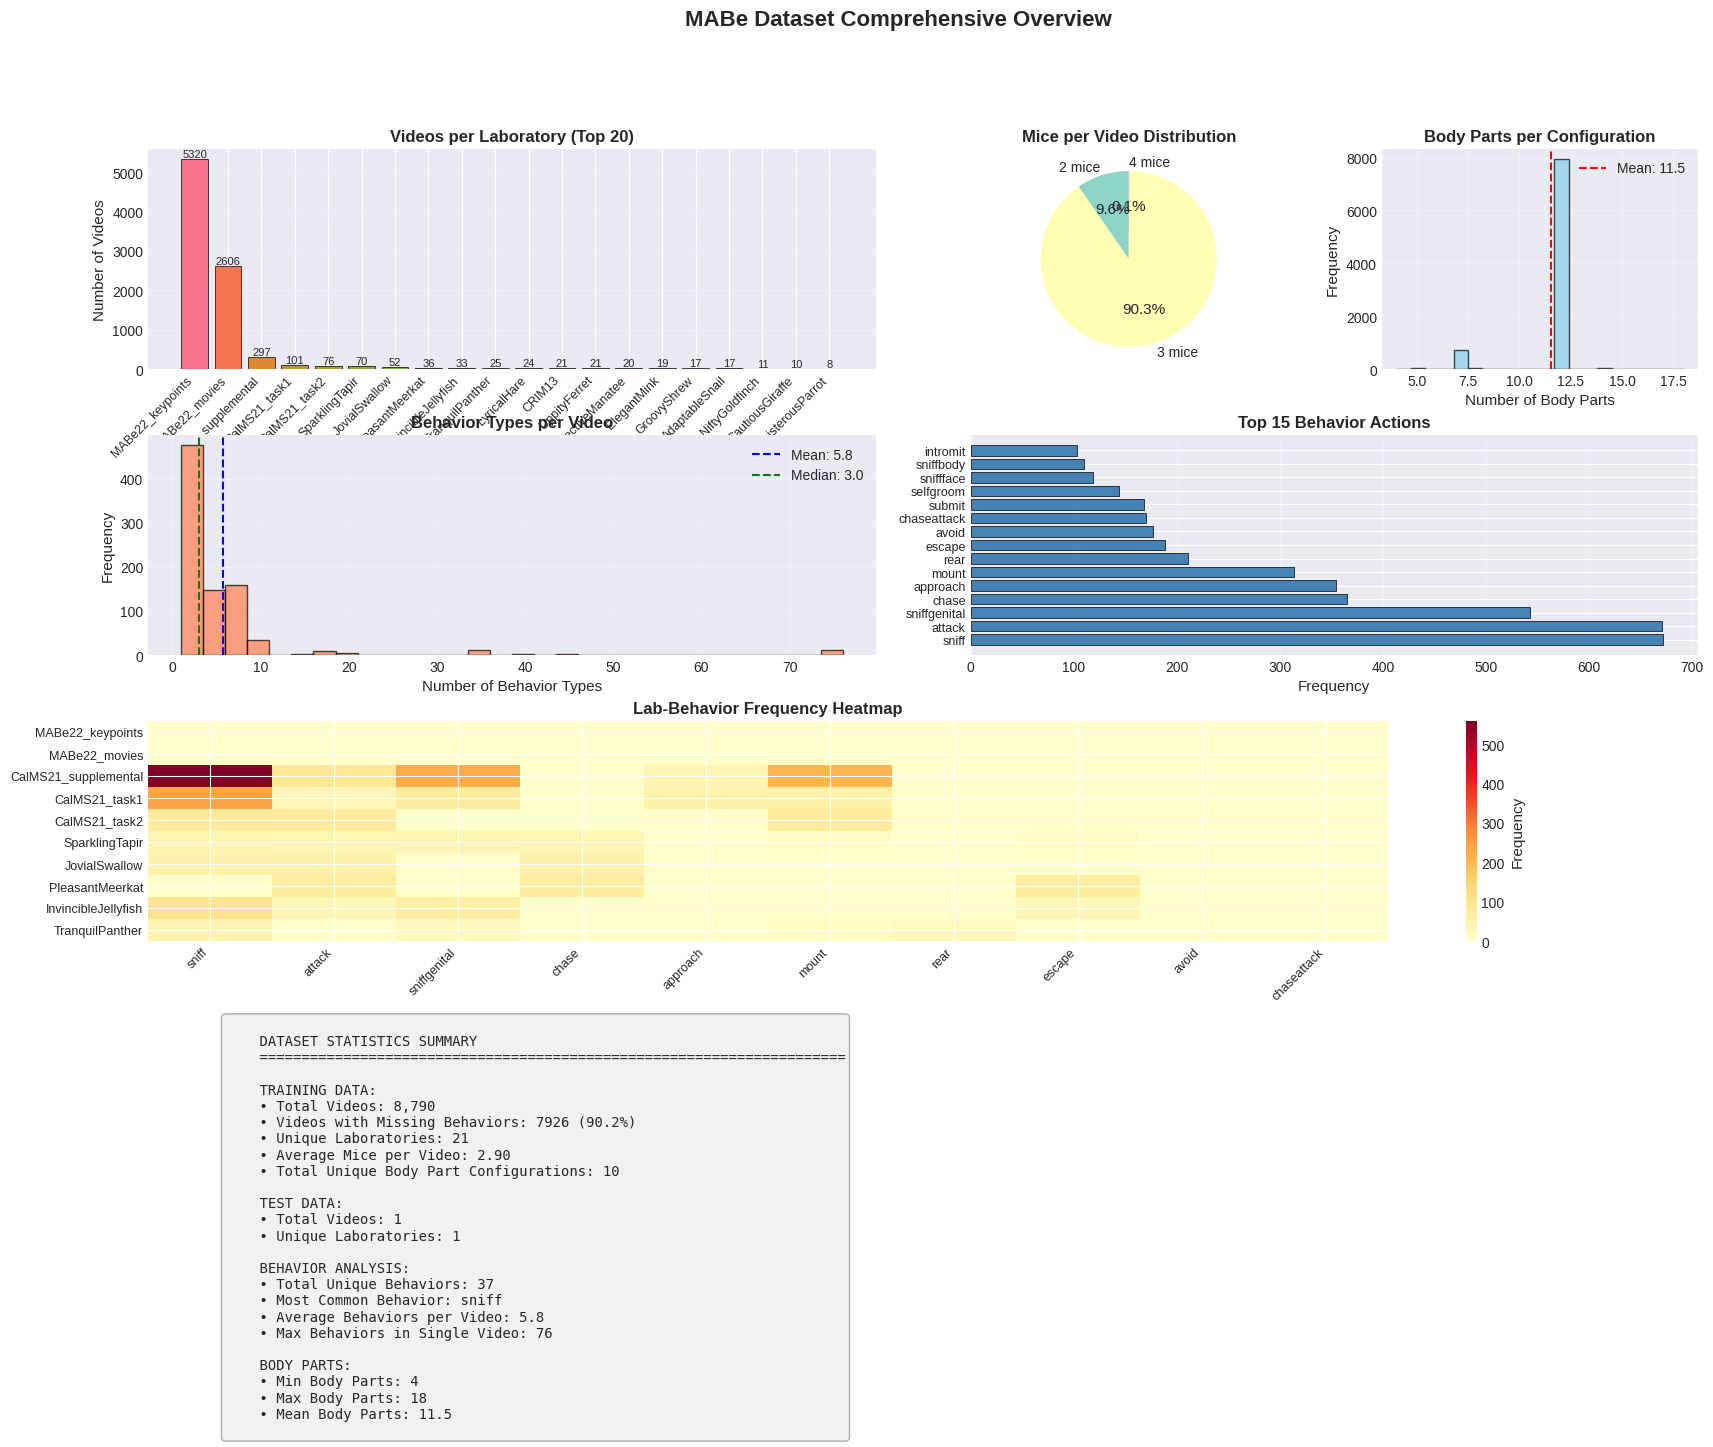


🎨 Creating interactive dashboard...


    💾 Saved interactive dashboard as HTML


In [5]:
# Data loading
print("\n" + "="*60)
print("📁 DATA LOADING AND INITIAL ANALYSIS")
print("="*60)

print("\n⏳ Loading training data...")
train = pd.read_csv('data/_provided/train.csv')
train['n_mice'] = 4 - train[['mouse1_strain', 'mouse2_strain', 'mouse3_strain', 'mouse4_strain']].isna().sum(axis=1)
train_without_mabe22 = train.query("~ lab_id.str.startswith('MABe22_')")

print("⏳ Loading test data...")
test = pd.read_csv('data/_provided/test.csv')
body_parts_tracked_list = list(np.unique(train.body_parts_tracked))

print("\n✅ DATA LOADING COMPLETE!")
print("-" * 60)
print(f"📊 Training Data Statistics:")
print(f"   • Total videos: {len(train):,}")
print(f"   • Videos after filtering: {len(train_without_mabe22):,}")
print(f"   • Videos with missing behaviors: {train['behaviors_labeled'].isna().sum()}")
print(f"   • Unique laboratories: {train['lab_id'].nunique()}")
print(f"   • Body part configurations: {len(body_parts_tracked_list)}")
print(f"\n📊 Test Data Statistics:")
print(f"   • Total videos: {len(test):,}")
print(f"   • Unique laboratories: {test['lab_id'].nunique()}")

print(f"\n🐭 Mice Distribution:")
for n_mice in sorted(train['n_mice'].unique()):
    count = (train['n_mice'] == n_mice).sum()
    pct = 100 * count / len(train)
    print(f"   • {n_mice} mouse/mice: {count:,} videos ({pct:.1f}%)")

if create_visualizations:
    try:
        behavior_counts = create_data_overview_plots(train, test)
        create_interactive_dashboard(train, test)
    except Exception as e:
        print(f"❌ Visualization failed: {e}")

In [6]:
def create_solution_df(dataset):
    solution = []
    for _, row in tqdm(dataset.iterrows(), total=len(dataset), desc="Creating solution"):
        lab_id = row['lab_id']
        if lab_id.startswith('MABe22'): 
            continue
        video_id = row['video_id']
        path = f"data/_provided/train_annotation/{lab_id}/{video_id}.parquet"
        try:
            annot = pd.read_parquet(path)
        except FileNotFoundError:
            if verbose: 
                print(f"No annotations for {path}")
            continue
        
        annot['lab_id'] = lab_id
        annot['video_id'] = video_id
        annot['behaviors_labeled'] = row['behaviors_labeled']
        annot['target_id'] = np.where(annot.target_id != annot.agent_id, 
                                     annot['target_id'].apply(lambda s: f"mouse{s}"), 'self')
        annot['agent_id'] = annot['agent_id'].apply(lambda s: f"mouse{s}")
        solution.append(annot)
    
    if solution:
        solution = pd.concat(solution)
    else:
        solution = pd.DataFrame()
    return solution



In [7]:
if validate_or_submit == 'validate':
    print("\n📋 Creating validation solution...")
    solution = create_solution_df(train_without_mabe22)
    print(f"   ✓ Solution created with {len(solution)} annotations")

In [ ]:
def generate_mouse_data(dataset, traintest, traintest_directory=None, generate_single=True, generate_pair=True):
    assert traintest in ['train', 'test']
    if traintest_directory is None:
        traintest_directory = f"data/_provided/{traintest}_tracking"
    
    for _, row in dataset.iterrows():
        lab_id = row.lab_id
        if lab_id.startswith('MABe22'): 
            continue
        video_id = row.video_id
        path = f"{traintest_directory}/{lab_id}/{video_id}.parquet"
        
        try:
            vid = pd.read_parquet(path)
            pvid = vid.pivot(columns=['mouse_id', 'bodypart'], index='video_frame', values=['x', 'y'])
            
            if pvid.isna().any().any():
                if verbose and traintest == 'test': 
                    print(f'Video {video_id}: missing values, {len(vid)} frames')
            else:
                if verbose and traintest == 'test': 
                    print(f'Video {video_id}: complete, {len(vid)} frames')
            
            del vid
            pvid = pvid.reorder_levels([1, 2, 0], axis=1).T.sort_index().T
            pvid /= row.pix_per_cm_approx
            
            # Handle NaN in behaviors_labeled
            if pd.isna(row.behaviors_labeled):
                continue
                
            vid_behaviors = json.loads(row.behaviors_labeled)
            vid_behaviors = sorted(list({b.replace("'", "") for b in vid_behaviors}))
            vid_behaviors = [b.split(',') for b in vid_behaviors]
            vid_behaviors = pd.DataFrame(vid_behaviors, columns=['agent', 'target', 'action'])
            
            if traintest == 'train':
                try:
                    annot = pd.read_parquet(path.replace('train_tracking', 'train_annotation'))
                except FileNotFoundError:
                    continue
            
            if generate_single:
                vid_behaviors_subset = vid_behaviors.query("target == 'self'")
                for mouse_id_str in np.unique(vid_behaviors_subset.agent):
                    try:
                        mouse_id = int(mouse_id_str[-1])
                        vid_agent_actions = np.unique(vid_behaviors_subset.query("agent == @mouse_id_str").action)
                        single_mouse = pvid.loc[:, mouse_id]
                        assert len(single_mouse) == len(pvid)
                        
                        single_mouse_meta = pd.DataFrame({
                            'video_id': video_id,
                            'agent_id': mouse_id_str,
                            'target_id': 'self',
                            'video_frame': single_mouse.index
                        })
                        
                        if traintest == 'train':
                            single_mouse_label = pd.DataFrame(0.0, columns=vid_agent_actions, index=single_mouse.index)
                            annot_subset = annot.query("(agent_id == @mouse_id) & (target_id == @mouse_id)")
                            for i in range(len(annot_subset)):
                                annot_row = annot_subset.iloc[i]
                                single_mouse_label.loc[annot_row['start_frame']:annot_row['stop_frame'], 
                                                     annot_row.action] = 1.0
                            yield 'single', single_mouse, single_mouse_meta, single_mouse_label
                        else:
                            if verbose: 
                                print(f'  Processing single mouse {mouse_id}')
                            yield 'single', single_mouse, single_mouse_meta, vid_agent_actions
                    except KeyError:
                        pass
            
            if generate_pair:
                vid_behaviors_subset = vid_behaviors.query("target != 'self'")
                if len(vid_behaviors_subset) > 0:
                    for agent, target in itertools.permutations(np.unique(pvid.columns.get_level_values('mouse_id')), 2):
                        agent_str = f"mouse{agent}"
                        target_str = f"mouse{target}"
                        vid_agent_actions = np.unique(vid_behaviors_subset.query(
                            "(agent == @agent_str) & (target == @target_str)").action)
                        
                        try:
                            mouse_pair = pd.concat([pvid[agent], pvid[target]], axis=1, keys=['A', 'B'])
                            assert len(mouse_pair) == len(pvid)
                            
                            mouse_pair_meta = pd.DataFrame({
                                'video_id': video_id,
                                'agent_id': agent_str,
                                'target_id': target_str,
                                'video_frame': mouse_pair.index
                            })
                            
                            if traintest == 'train':
                                mouse_pair_label = pd.DataFrame(0.0, columns=vid_agent_actions, index=mouse_pair.index)
                                annot_subset = annot.query("(agent_id == @agent) & (target_id == @target)")
                                for i in range(len(annot_subset)):
                                    annot_row = annot_subset.iloc[i]
                                    mouse_pair_label.loc[annot_row['start_frame']:annot_row['stop_frame'], 
                                                       annot_row.action] = 1.0
                                yield 'pair', mouse_pair, mouse_pair_meta, mouse_pair_label
                            else:
                                if verbose: 
                                    print(f'  Processing pair {agent} -> {target}')
                                yield 'pair', mouse_pair, mouse_pair_meta, vid_agent_actions
                        except KeyError:
                            pass
                            
        except Exception as e:
            if verbose:
                print(f"Error processing {video_id}: {e}")
            continue

def transform_single(single_mouse, body_parts_tracked):
    try:
        X = pd.DataFrame({
            f"{part1}+{part2}": np.square(single_mouse[part1] - single_mouse[part2]).sum(axis=1, skipna=False)
            for part1, part2 in itertools.combinations(body_parts_tracked, 2)
        })
        
        if 'ear_left' in single_mouse.columns and 'ear_right' in single_mouse.columns:
            if 'tail_base' in single_mouse.columns:
                shifted = single_mouse[['ear_left', 'ear_right', 'tail_base']].shift(10)
                X = pd.concat([
                    X, 
                    pd.DataFrame({
                        'speed_left': np.square(single_mouse['ear_left'] - shifted['ear_left']).sum(axis=1, skipna=False),
                        'speed_right': np.square(single_mouse['ear_right'] - shifted['ear_right']).sum(axis=1, skipna=False),
                        'speed_left2': np.square(single_mouse['ear_left'] - shifted['tail_base']).sum(axis=1, skipna=False),
                        'speed_right2': np.square(single_mouse['ear_right'] - shifted['tail_base']).sum(axis=1, skipna=False),
                    })
                ], axis=1)
            else:
                shifted = single_mouse[['ear_left', 'ear_right']].shift(10)
                X = pd.concat([
                    X,
                    pd.DataFrame({
                        'speed_left': np.square(single_mouse['ear_left'] - shifted['ear_left']).sum(axis=1, skipna=False),
                        'speed_right': np.square(single_mouse['ear_right'] - shifted['ear_right']).sum(axis=1, skipna=False),
                    })
                ], axis=1)
        
        performance_metrics['features_extracted'] += len(X.columns)
        return X
        
    except Exception as e:
        if verbose:
            print(f"    Transform error: {e}")
        return pd.DataFrame(index=single_mouse.index)

def transform_pair(mouse_pair, body_parts_tracked):
    try:
        drop_body_parts = ['ear_left', 'ear_right', 'headpiece_bottombackleft', 
                          'headpiece_bottombackright', 'headpiece_bottomfrontleft',
                          'headpiece_bottomfrontright', 'headpiece_topbackleft',
                          'headpiece_topbackright', 'headpiece_topfrontleft',
                          'headpiece_topfrontright', 'tail_midpoint']
        
        if len(body_parts_tracked) > 5:
            body_parts_tracked = [b for b in body_parts_tracked if b not in drop_body_parts]
        
        X = pd.DataFrame({
            f"12+{part1}+{part2}": np.square(mouse_pair['A'][part1] - mouse_pair['B'][part2]).sum(axis=1, skipna=False)
            for part1, part2 in itertools.product(body_parts_tracked, repeat=2)
        })
        
        if ('A', 'ear_left') in mouse_pair.columns and ('B', 'ear_left') in mouse_pair.columns:
            shifted_A = mouse_pair['A']['ear_left'].shift(10)
            shifted_B = mouse_pair['B']['ear_left'].shift(10)
            X = pd.concat([
                X,
                pd.DataFrame({
                    'speed_left_A': np.square(mouse_pair['A']['ear_left'] - shifted_A).sum(axis=1, skipna=False),
                    'speed_left_AB': np.square(mouse_pair['A']['ear_left'] - shifted_B).sum(axis=1, skipna=False),
                    'speed_left_B': np.square(mouse_pair['B']['ear_left'] - shifted_B).sum(axis=1, skipna=False),
                })
            ], axis=1)
        
        performance_metrics['features_extracted'] += len(X.columns)
        return X
        
    except Exception as e:
        if verbose:
            print(f"    Transform error: {e}")
        return pd.DataFrame(index=mouse_pair.index)

threshold = 0.27

def predict_multiclass(pred, meta):
    ama = np.argmax(pred, axis=1)
    ama = np.where(pred.max(axis=1) >= threshold, ama, -1)
    ama = pd.Series(ama, index=meta.video_frame)
    
    changes_mask = (ama != ama.shift(1)).values
    ama_changes = ama[changes_mask]
    meta_changes = meta[changes_mask]
    
    mask = ama_changes.values >= 0
    mask[-1] = False
    
    submission_part = pd.DataFrame({
        'video_id': meta_changes['video_id'][mask].values,
        'agent_id': meta_changes['agent_id'][mask].values,
        'target_id': meta_changes['target_id'][mask].values,
        'action': pred.columns[ama_changes[mask].values],
        'start_frame': ama_changes.index[mask],
        'stop_frame': ama_changes.index[1:][mask[:-1]]
    })
    
    stop_video_id = meta_changes['video_id'][1:][mask[:-1]].values
    stop_agent_id = meta_changes['agent_id'][1:][mask[:-1]].values
    stop_target_id = meta_changes['target_id'][1:][mask[:-1]].values
    
    for i in range(len(submission_part)):
        video_id = submission_part.video_id.iloc[i]
        agent_id = submission_part.agent_id.iloc[i]
        target_id = submission_part.target_id.iloc[i]
        
        if i >= len(stop_video_id) or stop_video_id[i] != video_id or \
           stop_agent_id[i] != agent_id or stop_target_id[i] != target_id:
            new_stop_frame = meta.query("(video_id == @video_id)").video_frame.max() + 1
            submission_part.iat[i, submission_part.columns.get_loc('stop_frame')] = new_stop_frame
    
    assert (submission_part.stop_frame > submission_part.start_frame).all(), 'stop <= start'
    
    performance_metrics['predictions_made'] += len(submission_part)
    if verbose: 
        print(f'  Actions found: {len(submission_part)}')
    
    return submission_part

def cross_validate_classifier(binary_classifier, X, label, meta):
    global f1_list, submission_list
    
    oof = pd.DataFrame(index=meta.video_frame)
    
    print(f"\n  🔄 Cross-validating {len(label.columns)} actions...")
    
    for action in label.columns:
        action_mask = ~label[action].isna().values
        X_action = X[action_mask]
        y_action = label[action][action_mask].values.astype(int)
        p = y_action.mean()
        baseline_score = p / (1 + p) if p > 0 else 0
        groups_action = meta.video_id[action_mask]
        
        performance_metrics['actions_processed'] += 1
        
        if len(np.unique(groups_action)) < 5:
            continue
        
        if not (y_action == 0).all():
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', category=RuntimeWarning)
                oof_action = cross_val_predict(binary_classifier, X_action, y_action, 
                                             groups=groups_action, cv=GroupKFold(), 
                                             method='predict_proba')
            oof_action = oof_action[:, 1]
        else:
            oof_action = np.zeros(len(y_action))
        
        f1 = f1_score(y_action, (oof_action >= threshold), zero_division=0)
        ch = '↑' if f1 > baseline_score else '=' if f1 == baseline_score else '↓'
        print(f"    • F1: {f1:.3f} {ch} (baseline: {baseline_score:.3f}) - {action}")
        f1_list.append((body_parts_tracked_str, action, f1))
        
        oof_column = np.zeros(len(label))
        oof_column[action_mask] = oof_action
        oof[action] = oof_column
    
    submission_part = predict_multiclass(oof, meta)
    submission_list.append(submission_part)

def submit(body_parts_tracked_str, switch_tr, binary_classifier, X_tr, label, meta):
    global submission_list
    
    model_list = []
    
    print(f"\n  🎯 Training models for {len(label.columns)} actions...")
    
    for action in label.columns:
        action_mask = ~label[action].isna().values
        y_action = label[action][action_mask].values.astype(int)
        
        performance_metrics['actions_processed'] += 1
        
        if not (y_action == 0).all():
            model = clone(binary_classifier)
            model.fit(X_tr[action_mask], y_action)
            assert len(model.classes_) == 2
            model_list.append((action, model))
            performance_metrics['models_trained'] += 1
    
    body_parts_tracked = json.loads(body_parts_tracked_str)
    test_subset = test[test.body_parts_tracked == body_parts_tracked_str]
    
    if len(test_subset) == 0:
        if verbose:
            print(f"  No test videos for this configuration")
        return
    
    generator = generate_mouse_data(test_subset, 'test',
                                  generate_single=(switch_tr == 'single'), 
                                  generate_pair=(switch_tr == 'pair'))
    
    if verbose: 
        print(f"  📹 Processing {len(test_subset)} test videos")
    
    for switch_te, data_te, meta_te, actions_te in generator:
        assert switch_te == switch_tr
        try:
            if switch_te == 'single':
                X_te = transform_single(data_te, body_parts_tracked)
            else:
                X_te = transform_pair(data_te, body_parts_tracked)
            
            if X_te.empty or len(X_te.columns) == 0:
                if verbose:
                    print("  Skipping due to transform failure")
                continue
            
            del data_te
            
            pred = pd.DataFrame(index=meta_te.video_frame)
            for action, model in model_list:
                if action in actions_te:
                    try:
                        pred[action] = model.predict_proba(X_te)[:, 1]
                    except:
                        pass
            
            del X_te
            
            if pred.shape[1] != 0:
                submission_part = predict_multiclass(pred, meta_te)
                submission_list.append(submission_part)
                    
        except Exception as e:
            if verbose: 
                print(f'  Error during prediction: {e}')
            if 'data_te' in locals():
                del data_te

def robustify(submission, dataset, traintest, traintest_directory=None):
    if traintest_directory is None:
        traintest_directory = f"data/_provided/{traintest}_tracking"
    
    if submission is None or len(submission) == 0:
        submission = pd.DataFrame(columns=['video_id', 'agent_id', 'target_id', 
                                          'action', 'start_frame', 'stop_frame'])
    
    if len(submission) > 0 and 'start_frame' in submission.columns and 'stop_frame' in submission.columns:
        old_len = len(submission)
        submission = submission[submission.start_frame < submission.stop_frame]
        if len(submission) != old_len:
            print(f"  🧹 Cleaned: Dropped {old_len - len(submission)} invalid frames")
    
    if len(submission) > 0:
        group_list = []
        for _, group in submission.groupby(['video_id', 'agent_id', 'target_id']):
            group = group.sort_values('start_frame')
            mask = np.ones(len(group), dtype=bool)
            last_stop_frame = 0
            for i, (_, row) in enumerate(group.iterrows()):
                if row['start_frame'] < last_stop_frame:
                    mask[i] = False
                else:
                    last_stop_frame = row['stop_frame']
            group_list.append(group[mask])
        
        if group_list:
            submission = pd.concat(group_list)
    
    s_list = []
    videos_filled = 0
    for idx, row in dataset.iterrows():
        lab_id = row['lab_id']
        if lab_id.startswith('MABe22'):
            continue
        video_id = row['video_id']
        
        if len(submission) == 0 or not (submission.video_id == video_id).any():
            videos_filled += 1
            
            try:
                path = f"{traintest_directory}/{lab_id}/{video_id}.parquet"
                vid = pd.read_parquet(path)
                
                # Handle NaN in behaviors_labeled
                if pd.isna(row['behaviors_labeled']):
                    s_list.append((video_id, 'mouse1', 'self', 'rear', 0, 50))
                    continue
                    
                vid_behaviors = eval(row['behaviors_labeled'])
                vid_behaviors = sorted(list({b.replace("'", "") for b in vid_behaviors}))
                vid_behaviors = [b.split(',') for b in vid_behaviors]
                vid_behaviors = pd.DataFrame(vid_behaviors, columns=['agent', 'target', 'action'])
                
                start_frame = int(vid.video_frame.min())
                stop_frame = int(vid.video_frame.max() + 1)
                
                for (agent, target), actions in vid_behaviors.groupby(['agent', 'target']):
                    batch_length = int(np.ceil((stop_frame - start_frame) / len(actions)))
                    for i, (_, action_row) in enumerate(actions.iterrows()):
                        batch_start = start_frame + i * batch_length
                        batch_stop = min(batch_start + batch_length, stop_frame)
                        s_list.append((video_id, agent, target, action_row['action'], 
                                     batch_start, batch_stop))
            except:
                s_list.append((video_id, 'mouse1', 'self', 'rear', 0, 50))
    
    if len(s_list) > 0:
        new_df = pd.DataFrame(s_list, columns=['video_id', 'agent_id', 'target_id', 
                                               'action', 'start_frame', 'stop_frame'])
        if len(submission) > 0:
            submission = pd.concat([submission, new_df], ignore_index=True)
        else:
            submission = new_df
        print(f"  📝 Filled {videos_filled} empty videos with default predictions")
    
    submission = submission.reset_index(drop=True)
    return submission

In [9]:
# Main processing loop
print("\n" + "="*80)
print(" "*20 + "🚀 STARTING MAIN PROCESSING PIPELINE 🚀")
print("="*80)

f1_list = []
submission_list = []
predictions_per_config = []
config_times = []

total_configs = len(body_parts_tracked_list) - 1
print(f"\n📋 Total configurations to process: {total_configs}")
print("-" * 60)


                    🚀 STARTING MAIN PROCESSING PIPELINE 🚀

📋 Total configurations to process: 9
------------------------------------------------------------


In [10]:
for section in range(1, len(body_parts_tracked_list)):
    body_parts_tracked_str = body_parts_tracked_list[section]
    config_start_time = time.time()
    
    print(f"\n{'='*60}")
    print(f"🔧 Configuration {section}/{total_configs}")
    print(f"{'='*60}")
    
    try:
        body_parts_tracked = json.loads(body_parts_tracked_str)
        print(f"📍 Processing videos with {len(body_parts_tracked)} body parts")
        print(f"   Body parts: {', '.join(body_parts_tracked[:5])}{'...' if len(body_parts_tracked) > 5 else ''}")
        
        train_subset = train[train.body_parts_tracked == body_parts_tracked_str]
        
        if len(train_subset) == 0:
            print("  ⚠️ No training data for this configuration")
            continue
        
        print(f"  📊 Found {len(train_subset)} training videos")
        performance_metrics['configurations_processed'] += 1
        
        single_mouse_list = []
        single_mouse_label_list = []
        single_mouse_meta_list = []
        mouse_pair_list = []
        mouse_pair_label_list = []
        mouse_pair_meta_list = []
        
        print("  📥 Collecting training data...")
        for switch, data, meta, label in generate_mouse_data(train_subset, 'train'):
            if switch == 'single':
                single_mouse_list.append(data)
                single_mouse_meta_list.append(meta)
                single_mouse_label_list.append(label)
            else:
                mouse_pair_list.append(data)
                mouse_pair_meta_list.append(meta)
                mouse_pair_label_list.append(label)
        
        binary_classifier = make_pipeline(
            SimpleImputer(),
            StandardScaler(),
            TrainOnSubsetClassifier(KNeighborsClassifier(n_neighbors=11), 20000)
        )
        
        config_predictions = performance_metrics['predictions_made']
        
        if len(single_mouse_list) > 0:
            try:
                print(f"\n  🐭 Processing {len(single_mouse_list)} single mouse batches")
                performance_metrics['single_mouse_batches'] += len(single_mouse_list)
                
                single_mouse = pd.concat(single_mouse_list)
                single_mouse_label = pd.concat(single_mouse_label_list)
                single_mouse_meta = pd.concat(single_mouse_meta_list)
                
                del single_mouse_list, single_mouse_label_list, single_mouse_meta_list
                
                X_tr = transform_single(single_mouse, body_parts_tracked)
                
                if not X_tr.empty and len(X_tr.columns) > 0:
                    del single_mouse
                    print(f"  ✅ Features shape: {X_tr.shape}")
                    
                    if validate_or_submit == 'validate':
                        cross_validate_classifier(binary_classifier, X_tr, single_mouse_label, 
                                                single_mouse_meta)
                    else:
                        submit(body_parts_tracked_str, 'single', binary_classifier, X_tr, 
                              single_mouse_label, single_mouse_meta)
                    
                    if create_visualizations and section <= 2:
                        try:
                            create_feature_analysis_plots(X_tr, 'single', section)
                        except Exception as e:
                            print(f"  ⚠️ Feature analysis plot failed: {e}")
                    
                    del X_tr
                else:
                    print("  ⚠️ Transform failed for single mouse")
                    del single_mouse
                    
                gc.collect()
                
            except Exception as e:
                print(f"  ❌ Exception in single mouse: {e}")
        
        if len(mouse_pair_list) > 0:
            try:
                print(f"\n  🐭🐭 Processing {len(mouse_pair_list)} mouse pair batches")
                performance_metrics['pair_batches'] += len(mouse_pair_list)
                
                mouse_pair = pd.concat(mouse_pair_list)
                mouse_pair_label = pd.concat(mouse_pair_label_list)
                mouse_pair_meta = pd.concat(mouse_pair_meta_list)
                
                del mouse_pair_list, mouse_pair_label_list, mouse_pair_meta_list
                
                X_tr = transform_pair(mouse_pair, body_parts_tracked)
                
                if not X_tr.empty and len(X_tr.columns) > 0:
                    del mouse_pair
                    print(f"  ✅ Features shape: {X_tr.shape}")
                    
                    if validate_or_submit == 'validate':
                        cross_validate_classifier(binary_classifier, X_tr, mouse_pair_label, 
                                                mouse_pair_meta)
                    else:
                        submit(body_parts_tracked_str, 'pair', binary_classifier, X_tr, 
                              mouse_pair_label, mouse_pair_meta)
                    
                    if create_visualizations and section <= 2:
                        try:
                            create_feature_analysis_plots(X_tr, 'pair', section)
                        except Exception as e:
                            print(f"  ⚠️ Feature analysis plot failed: {e}")
                    
                    del X_tr
                else:
                    print("  ⚠️ Transform failed for mouse pair")
                    del mouse_pair
                    
                gc.collect()
                
            except Exception as e:
                print(f"  ❌ Exception in mouse pair: {e}")
        
        config_time = time.time() - config_start_time
        config_times.append(config_time)
        predictions_per_config.append(performance_metrics['predictions_made'] - config_predictions)
        
        print(f"\n  ⏱️ Configuration processing time: {config_time:.2f} seconds")
            
    except Exception as e:
        print(f"  ❌ Exception in section {section}: {e}")
        continue
    
    print("")


🔧 Configuration 1/9
📍 Processing videos with 18 body parts
   Body parts: body_center, ear_left, ear_right, headpiece_bottombackleft, headpiece_bottombackright...
  📊 Found 7 training videos
  📥 Collecting training data...

  🐭 Processing 22 single mouse batches
  ✅ Features shape: (544859, 157)

  🎯 Training models for 1 actions...
  📹 Processing 1 test videos
Video 438887472: missing values, 1089866 frames
  Processing single mouse 1
  Actions found: 93
  Processing single mouse 2
  Actions found: 656
  Processing single mouse 3
  Actions found: 509
  Processing single mouse 4
    Transform error: 'neck'
  Skipping due to transform failure

📈 Creating feature analysis for single mouse...
    ⚠️ No numeric features to visualize

  🐭🐭 Processing 72 mouse pair batches
  ✅ Features shape: (1744248, 52)

  🎯 Training models for 6 actions...
  📹 Processing 1 test videos
Video 438887472: missing values, 1089866 frames
  Processing pair 1 -> 2
  Actions found: 5
  Processing pair 1 -> 3
  A

In [11]:
if create_visualizations and f1_list:
    try:
        create_performance_tracking_plot(f1_list, predictions_per_config)
    except Exception as e:
        print(f"❌ Performance tracking plot failed: {e}")

print("\n" + "="*80)
print("📋 FINALIZING SUBMISSION")
print("="*80)

if validate_or_submit == 'validate' and submission_list:
    submission = pd.concat(submission_list) if submission_list else pd.DataFrame()
    submission_robust = robustify(submission, train, 'train')
    if 'solution' in locals() and len(solution) > 0 and len(submission_robust) > 0:
        print(f"\n✅ OOF score: {score(solution, submission_robust, ''):.4f}")
    
    if f1_list:
        f1_df = pd.DataFrame(f1_list, columns=['body_parts', 'action', 'f1_score'])
        print(f"✅ Average binary F1: {f1_df['f1_score'].mean():.4f}")
        print(f"✅ Median binary F1: {f1_df['f1_score'].median():.4f}")
        print(f"✅ Best F1: {f1_df['f1_score'].max():.4f}")
        print(f"✅ Worst F1: {f1_df['f1_score'].min():.4f}")

elif validate_or_submit == 'submit':
    if submission_list:
        submission = pd.concat(submission_list)
        print(f"\n📊 Generated {len(submission)} predictions from models")
    else:
        submission = pd.DataFrame()
        print("\n⚠️ No predictions generated from models")
    
    submission_robust = robustify(submission, test, 'test')
    submission_robust.index.name = 'row_id'
    submission_robust.to_csv('submission.csv')
    
    print(f"\n✅ Final submission: {len(submission_robust)} rows")
    print("✅ Saved to submission.csv")
    
    print("\n📊 Submission Statistics:")
    if len(submission_robust) > 0:
        action_counts = submission_robust['action'].value_counts()
        print(f"   • Unique actions: {submission_robust['action'].nunique()}")
        print(f"   • Unique videos: {submission_robust['video_id'].nunique()}")
        print(f"   • Top 5 predicted actions:")
        for i, (action, count) in enumerate(action_counts.head(5).items(), 1):
            print(f"      {i}. {action}: {count} ({100*count/len(submission_robust):.1f}%)")
    
    print("\nFirst 10 rows of submission:")
    print(submission_robust.head(10))

elapsed_time = time.time() - start_time
print("\n" + "="*80)
print("📊 PERFORMANCE SUMMARY")
print("="*80)
print(f"⏱️ Total execution time: {elapsed_time:.2f} seconds ({elapsed_time/60:.1f} minutes)")
print(f"🔧 Configurations processed: {performance_metrics['configurations_processed']}")
print(f"🐭 Single mouse batches: {performance_metrics['single_mouse_batches']}")
print(f"🐭🐭 Pair batches: {performance_metrics['pair_batches']}")
print(f"📐 Features extracted: {performance_metrics['features_extracted']:,}")
print(f"🎯 Predictions made: {performance_metrics['predictions_made']:,}")
print(f"🤖 Models trained: {performance_metrics['models_trained']}")
print(f"🎬 Actions processed: {performance_metrics['actions_processed']}")

if config_times:
    print(f"\n⏱️ Processing Time Statistics:")
    print(f"   • Mean time per config: {np.mean(config_times):.2f} seconds")
    print(f"   • Median time per config: {np.median(config_times):.2f} seconds")
    print(f"   • Total processing time: {sum(config_times):.2f} seconds")
    print(f"   • Fastest config: {min(config_times):.2f} seconds")
    print(f"   • Slowest config: {max(config_times):.2f} seconds")

print("\n" + "="*80)
print(" "*25 + "✨ ANALYSIS COMPLETE! ✨")
print("="*80)


📋 FINALIZING SUBMISSION

📊 Generated 1365 predictions from models

✅ Final submission: 1365 rows
✅ Saved to submission.csv

📊 Submission Statistics:
   • Unique actions: 6
   • Unique videos: 1
   • Top 5 predicted actions:
      1. rear: 1258 (92.2%)
      2. avoid: 40 (2.9%)
      3. approach: 33 (2.4%)
      4. chase: 19 (1.4%)
      5. attack: 13 (1.0%)

First 10 rows of submission:
         video_id agent_id target_id action  start_frame  stop_frame
row_id                                                              
0       438887472   mouse1    mouse2  avoid          824         825
1       438887472   mouse1    mouse2  avoid          838         846
2       438887472   mouse1    mouse2  chase         5530        5533
3       438887472   mouse1    mouse2  chase         5537        5539
4       438887472   mouse1    mouse2  chase        17969       17970
5       438887472   mouse1    mouse3  avoid         2293        2295
6       438887472   mouse1    mouse3  chase         9290 